
# Recommender System using Self-Supervised Graph Neural Networks

## Overview
This project implements a recommender system using self-supervised learning techniques with Graph Neural Networks (GNNs). The approach leverages the inherent structure of the data and self-supervised learning of **LightGCN** to enhance the recommendation quality without relying on labeled data.

## Features
- Self-supervised learning with LightGCN (GNN)
- Efficient handling of graph-structured data
- Enhanced recommendation performance through advanced neural network techniques

## Usage
To run the project, execute the following command:
```sh
jupyter notebook recommender-system-using-self-supervised-gnn.ipynb
```

## Project Structure
- `recommender-system-using-self-supervised-gnn.ipynb`: Main notebook containing the implementation of the recommender system.

## Results
The results of the recommender system are evaluated using standard metrics such as Precision, Recall, and F1-score. The self-supervised approach shows significant improvements over traditional methods.

## Contributing
Contributions are welcome! Please read the [contribution guidelines](CONTRIBUTING.md) first.


In [253]:
# Code cell
!pip install torch-geometric

In [254]:
# Import necessary libraries
import numpy as np
import pandas as pd
import random
import copy
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing
from torch_geometric.utils import degree
import torch
from torch import nn, optim, Tensor
# from torch_sparse import SparseTensor, matmul
import torch.nn.functional as F
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.data import download_url, extract_zip
from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj

from scipy import sparse

In [255]:
# Code cell
R = np.array([[0,0,1,1],[1,0,1,0],[0,1,0,0]])
print(R)

[[0 0 1 1]
 [1 0 1 0]
 [0 1 0 0]]


In [256]:
# Code cell
R_np_COO = sparse.coo_matrix(R)
print(R_np_COO)

  (0, 2)	1
  (0, 3)	1
  (1, 0)	1
  (1, 2)	1
  (2, 1)	1


In [257]:
# Code cell
R_edge_index = [R_np_COO.row, R_np_COO.col]
print(R_edge_index)

[array([0, 0, 1, 1, 2], dtype=int32), array([2, 3, 0, 2, 1], dtype=int32)]


In [258]:
# Code cell
print(R_np_COO.todense())

[[0 0 1 1]
 [1 0 1 0]
 [0 1 0 0]]


In [259]:
# Code cell
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movie_path = './ml-latest-small/movies.csv'
rating_path = './ml-latest-small/ratings.csv'
user_path = './ml-latest-small/users.csv'

Using existing file ml-latest-small.zip
Extracting ./ml-latest-small.zip


In [260]:
# Code cell
df_movie = pd.read_csv(movie_path)
df_rating = pd.read_csv(rating_path)

print(df_rating.describe())
df_rating.head()

print("Movies:", len(df_rating['movieId'].unique()))
print("Users:", len(df_rating['userId'].unique()))

              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8122.000000       4.000000  1.435994e+09
max       610.000000  193609.000000       5.000000  1.537799e+09
Movies: 9724
Users: 610


Label The movies cause movieIds are from 1 to 193609

In [261]:
# Preprocessing
user_labels = preprocessing.LabelEncoder()
movie_labels = preprocessing.LabelEncoder()

df_rating.userId = user_labels.fit_transform(df_rating.userId.values)
df_rating.movieId = movie_labels.fit_transform(df_rating.movieId.values)

In [262]:
# Code cell
print(df_rating.describe())

              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      325.127564    3101.735561       3.501557  1.205946e+09
std       182.618491    2627.050983       1.042529  2.162610e+08
min         0.000000       0.000000       0.500000  8.281246e+08
25%       176.000000     900.000000       3.000000  1.019124e+09
50%       324.000000    2252.000000       3.500000  1.186087e+09
75%       476.000000    5095.250000       4.000000  1.435994e+09
max       609.000000    9723.000000       5.000000  1.537799e+09


In [263]:
# Code cell
print(df_rating.rating.value_counts())

rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64


## Load Edge Indices

In [264]:
# Define functions
def load_edge_csv(df, src_index_col, dest_index_col, link_index_col, threshold=3):
  edge_index = None
  sources = [user for user in df['userId']]
  destinations = [movie for movie in df['movieId']]
  link_vals = df[link_index_col].values

  edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= threshold
  edge_index = [[],[]]
  edge_values = []

  for i in range(edge_attr.shape[0]):
    if edge_attr[i]:
      edge_index[0].append(sources[i])
      edge_index[1].append(destinations[i])
      edge_values.append(link_vals[i])

  return edge_index, edge_values


In [265]:
# Code cell
edge_index, edge_values = load_edge_csv(df_rating, 'userId', 'movieId', 'rating', threshold=1)

In [266]:
# Code cell
print(f'{len(edge_index)} x {len(edge_index[0])}')

2 x 99466


In [267]:
# Code cell
edge_index = torch.LongTensor(edge_index)
edge_index.size()

torch.Size([2, 99466])

In [268]:
# Code cell
edge_values = torch.tensor(edge_index)
edge_values.size()

/tmp/ipykernel_34/1511606919.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_values = torch.tensor(edge_index)


torch.Size([2, 99466])

In [269]:
# Code cell
num_movies, num_users = len(df_rating['movieId'].unique()), len(df_rating['userId'].unique())
num_interactions = edge_index.shape[1]
print(f'Number of movies: {num_movies}')
print(f'Number of users: {num_users}')
print(f'Number of interactions: {num_interactions}')

Number of movies: 9724
Number of users: 610
Number of interactions: 99466


### Splitting Dataset

In [270]:
# Train the model
all_indices = list(range(num_interactions))
train_indices, test_indices = train_test_split(all_indices, test_size=0.2, random_state=1)
val_indices, test_indices = train_test_split(test_indices, test_size=0.5, random_state=1)

train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]
print(len(train_edge_index[1]))
print(len(val_edge_index[1]))
print(len(test_edge_index[1]))

79572
9947
9947


### Conversion of Interaction matrix(R) to Adjacency Matrix(A)

In [271]:
# Define functions
def R_to_Adjacency_edge_index(edge_index):
  R = torch.zeros((num_users, num_movies))
  for i in range(edge_index.shape[1]):
    R[edge_index[0][i], edge_index[1][i]] = 1
  R_T = torch.transpose(R, 0, 1)
  A = torch.zeros((num_users+num_movies), (num_users+num_movies))
  A[:num_users, num_users:] = R.clone()
  A[num_users:, :num_users] = R_T.clone()
  A_coo = A.to_sparse_coo()
  A_coo = A_coo.indices()
  return A_coo

In [272]:
# Define functions
def Adjacency_edge_index_to_R_edge_index(edge_index):
  values = torch.ones(edge_index.size(1), device='cuda')

    # Create a sparse matrix using torch.sparse
  sparse_input_edge_mat = torch.sparse_coo_tensor(edge_index, values, size=(num_users + num_movies, num_users + num_movies))
  A = sparse_input_edge_mat.to_dense()
  R = A[:num_users, num_users:]
  R_COO = R.to_sparse_coo()
  R_edge_index = R_COO.indices()
  return R_edge_index

In [273]:
# Train the model
train_edge_index = R_to_Adjacency_edge_index(train_edge_index)
val_edge_index = R_to_Adjacency_edge_index(val_edge_index)
test_edge_index = R_to_Adjacency_edge_index(test_edge_index)

In [274]:
# Train the model
print(train_adj_edge_index.size())
print(val_adj_edge_index.size())
print(test_adj_edge_index.size())

torch.Size([2, 159144])
torch.Size([2, 19894])
torch.Size([2, 19894])


### Training & computing BPR Loss
Since this is Self-supervised Learning, we are relying on graph structure itself. So, we will random sample a batch of positives and negatives

In [275]:
# Define functions
def sample_mini_batch(batch_size, edge_index): # Note: edge_index is in interactive matrix form
  edges = structured_negative_sampling(edge_index)
  edges = torch.stack(edges, dim=0)
  mini_batch_sample_indices = random.choices(list(range(edges[0].shape[0])), k=batch_size)
  mini_batch_edges = edges[:, mini_batch_sample_indices]
  user_indices, positive_user_indices, negative_user_indices = mini_batch_edges[0], mini_batch_edges[1], mini_batch_edges[2]
  return user_indices, positive_user_indices, negative_user_indices

## LightGCN Model

In [276]:
# Define functions
class LightGCN(MessagePassing):
  def __init__(self, num_users, num_movies, embedding_dim=64, K=3, add_self_loops=False): # K = No.of layers
    super().__init__()
    self.num_users = num_users
    self.num_movies = num_movies
    self.embedding_dim = embedding_dim
    self.K = K
    self.add_self_loops = add_self_loops

    self.user_embedding = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim)
    self.movie_embedding = nn.Embedding(num_embeddings=self.num_movies, embedding_dim=self.embedding_dim)
    self.init_embedding()

  def init_embedding(self):
    nn.init.normal_(self.user_embedding.weight, std=0.1)
    nn.init.normal_(self.movie_embedding.weight, std=0.1)


  def forward(self, edge_index):
    edge_index_norm = gcn_norm(edge_index, add_self_loops=self.add_self_loops)

    emb_0 = torch.cat([self.user_embedding.weight, self.movie_embedding.weight])
    embs = [emb_0]
    emb_k = emb_0

    for i in range(self.K):
      emb_k = self.propagate(edge_index=edge_index_norm[0], x=emb_k, norm=edge_index_norm[1])
      embs.append(emb_k)

    embs = torch.stack(embs, dim=1)
    lightgcn_all_embeddings = torch.mean(embs, dim=1)

    user_embeddings, movie_embeddings = torch.split(lightgcn_all_embeddings, [self.num_users, self.num_movies])

    return user_embeddings, self.user_embedding.weight, movie_embeddings, self.movie_embedding.weight

  def message(self, x_j, norm):
    return norm.view(-1, 1) * x_j

### Loss Fn

In [277]:
# Define functions
def bpr_loss(user_emb_final, user_emb_0, positive_emb_final, positive_emb_0, negative_emb_final, negative_emb_0, lambda_val):
  reg_loss = lambda_val * (user_emb_0.norm(2).pow(2) + positive_emb_0.norm(2).pow(2) + negative_emb_0.norm(2).pow(2))

  pos_scores = torch.sum(torch.mul(user_emb_final, positive_emb_final), dim=-1)
  neg_scores = torch.sum(torch.mul(user_emb_final, negative_emb_final), dim=-1)

  bpr_loss = -torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))

  return bpr_loss + reg_loss

### Evaluation Metrics

In [278]:
# Define functions
# Generates positive items dict for each user
def get_user_pos_items(edge_index):
  user_pos_items={}
  for i in range(edge_index.shape[1]):
    user = edge_index[0][i].item()
    item = edge_index[1][i].item()

    if user not in user_pos_items:
      user_pos_items[user] = []
    user_pos_items[user].append(item)
  return user_pos_items

# Computes Recall@k, precision@k
def RecallPrecision_ATk(groundTruth, r, k):
  num_correct_predicted = torch.sum(r, dim=-1)
  user_num_liked = torch.Tensor([len(groundTruth[i]) for i in range(len(groundTruth))])

  recall = torch.mean(num_correct_predicted / user_num_liked)
  precision = torch.mean(num_correct_predicted / k)
  return recall.item(), precision.item()

# Computes NDCG@k
def NDCGatK_r(groundTruth, r, k):
  assert len(groundTruth)==len(r)
  test_matrix = torch.zeros((len(r), k))

  for i, items in enumerate(groundTruth):
    length = min(len(items), k)
    test_matrix[i, :length] = 1

  max_r = test_matrix
  idcg = torch.sum(max_r * 1./torch.log2(torch.arange(2, k + 2)), axis=1)
  dcg = r * 1./torch.log2(torch.arange(2, k + 2))
  dcg = torch.sum(dcg, axis=1)
  idcg[idcg == 0.] = 1.
  ndcg = dcg/idcg
  ndcg[torch.isnan(ndcg)] = 0.
  return torch.mean(ndcg).item()

In [279]:
# Define functions
def get_metrics(model, input_edge_index, input_exclude_indices, k):
  user_embedding = model.user_embedding.weight
  movie_embedding = model.movie_embedding.weight

  edge_index = Adjacency_edge_index_to_R_edge_index(input_edge_index)
  exclude_edge_indices = [Adjacency_edge_index_to_R_edge_index(input_exclude_indices[i]) for i in range(len(input_exclude_indices))]

  r_mat_rating = torch.matmul(user_embedding, movie_embedding.T)
  # shape of rating: num_users x num_movies
  rating = r_mat_rating

  for i in range(len(exclude_edge_indices)):
    user_pos_items = get_user_pos_items(exclude_edge_indices[i])
    exclude_users = []
    exclude_items = []
    for user, items in user_pos_items.items():
      exclude_users.extend([user]*len(items))
      exclude_items.extend(items)

    # Set the excluded entry to very small number
    rating[exclude_users, exclude_items] = - (1<<10)
  # get top k recommended items from each user:
  _, top_k_items = torch.topk(rating, k=k)

  # get all users in evaluated split
  users = edge_index[0].unique()

  test_user_pos_items = get_user_pos_items(input_edge_index)
  test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

  r = []
  for user in users:
    user_true_relevant_item = test_user_pos_items[user.item()]
    user_top_k_items = top_k_items[user]
    label = list(map(lambda x: x in user_true_relevant_item, user_top_k_items))
    r.append(label)

  r = torch.Tensor(np.array(r).astype('float'))

  recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
  ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

  return recall, precision, ndcg


### Evaluate Model


In [280]:
# Define functions
def evaluate_model(model, edge_index, exclude_indices, k, lambda_val):
  # 1. Get embeddings:
  user_embeddings, user_embedding_0, movie_embeddings, movie_embedding_0 = model.forward(edge_index)
  r_mat_edge_index = Adjacency_edge_index_to_R_edge_index(edge_index)
  edges = structured_negative_sampling(r_mat_edge_index, contains_neg_self_loops=False)
  user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]

  user_emb_final = user_embeddings[user_indices]
  pos_emb_final = movie_embeddings[pos_item_indices]
  neg_emb_final = movie_embeddings[neg_item_indices]

  user_emb_0 = user_embedding_0[user_indices]
  pos_emb_0 = movie_embedding_0[pos_item_indices]
  neg_emb_0 = movie_embedding_0[neg_item_indices]

  recall, precision, ndcg = get_metrics(model, edge_index, exclude_indices, k)
  bpr_loss_val = bpr_loss(user_emb_final, user_emb_0, pos_emb_final, pos_emb_0, neg_emb_final, neg_emb_0, lambda_val)

  return recall, precision, ndcg, bpr_loss_val

## Training

### Hyperparameters

In [286]:
# Code cell
ITERATIONS = 10000
EPOCHS = 10
BATCH_SIZE = 1024
K = 20
LR = 1e-2
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
LAMBDA = 1e-6

### Setup

In [287]:
# Code cell
model = LightGCN(num_users, num_movies, K=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [288]:
# Train the model
model = model.to(device)

model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)
test_edge_index = test_edge_index.to(device)

In [289]:
# Define functions
# Helper func to get embeddings for BPR loss
def get_embs_for_bpr(model, edge_index):
  user_embeddings, user_embedding_0, movie_embeddings, movie_embedding_0 = model.forward(edge_index)

  edge_index_to_use = Adjacency_edge_index_to_R_edge_index(edge_index)

  user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(BATCH_SIZE, edge_index_to_use)

  user_indices = user_indices.to(device)
  pos_item_indices = pos_item_indices.to(device)
  neg_item_indices = neg_item_indices.to(device)
  user_emb_final = user_embeddings[user_indices]
  pos_emb_final = movie_embeddings[pos_item_indices]
  neg_emb_final = movie_embeddings[neg_item_indices]
  user_emb_0 = user_embedding_0[user_indices]
  pos_emb_0 = movie_embedding_0[pos_item_indices]
  neg_emb_0 = movie_embedding_0[neg_item_indices]

  return user_emb_final, pos_emb_final, neg_emb_final, user_emb_0, pos_emb_0, neg_emb_0

### Training loop

In [290]:
# Train the model
train_losses = []
val_losses = []
val_recall_at_k = []
val_precision_at_k = []

for iter in tqdm(range(ITERATIONS)):
  user_emb_final, pos_emb_final, neg_emb_final, user_emb_0, pos_emb_0, neg_emb_0 = get_embs_for_bpr(model, train_edge_index)

  bpr_loss_val = bpr_loss(user_emb_final, user_emb_0, pos_emb_final, pos_emb_0, neg_emb_final, neg_emb_0, LAMBDA)

  optimizer.zero_grad()
  bpr_loss_val.backward()
  optimizer.step()

  # val set
  if iter % ITERS_PER_EVAL == 0:
    model.eval()

    with torch.no_grad():
      val_recall, val_precision, val_ndcg, val_bpr_loss = evaluate_model(model, val_edge_index, [train_edge_index], K, LAMBDA)
      print(f"[Iteration {iter}/{ITERATIONS}] train_BPR_loss: {bpr_loss_val}, val_BPR Loss: {val_bpr_loss}, Recall: {val_recall}, Precision: {val_precision}, NDCG: {val_ndcg}")

      train_losses.append(bpr_loss_val.item())
      val_losses.append(val_bpr_loss.item())
      val_recall_at_k.append(val_recall)
      val_precision_at_k.append(val_precision)

    model.train()

  if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
    scheduler.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

[Iteration 0/10000] train_BPR_loss: -0.6902770400047302, val_BPR Loss: -0.6663734912872314, Recall: 0.0008100141421891749, Precision: 0.0009166667005047202, NDCG: 0.0011020890669897199
[Iteration 200/10000] train_BPR_loss: -26.980113983154297, val_BPR Loss: -11.844123840332031, Recall: 0.0037586847320199013, Precision: 0.001416666666045785, NDCG: 0.0022203971166163683
[Iteration 400/10000] train_BPR_loss: -118.60968017578125, val_BPR Loss: -52.000431060791016, Recall: 0.005049459170550108, Precision: 0.003416666528210044, NDCG: 0.00428718701004982
[Iteration 600/10000] train_BPR_loss: -275.01123046875, val_BPR Loss: -111.92060089111328, Recall: 0.004916463512927294, Precision: 0.002250000135973096, NDCG: 0.003940091002732515
[Iteration 800/10000] train_BPR_loss: -414.764892578125, val_BPR Loss: -185.4910888671875, Recall: 0.0047150603495538235, Precision: 0.0020000000949949026, NDCG: 0.004125772509723902
[Iteration 1000/10000] train_BPR_loss: -653.6842041015625, val_BPR Loss: -274.1879

## Plotting

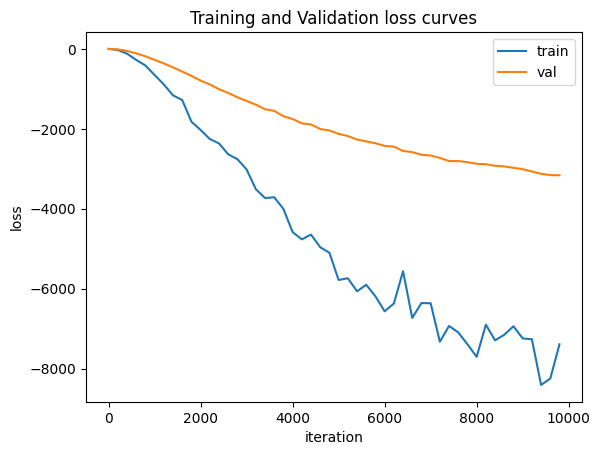

In [291]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='val')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Training and Validation loss curves')
plt.legend()
plt.show()

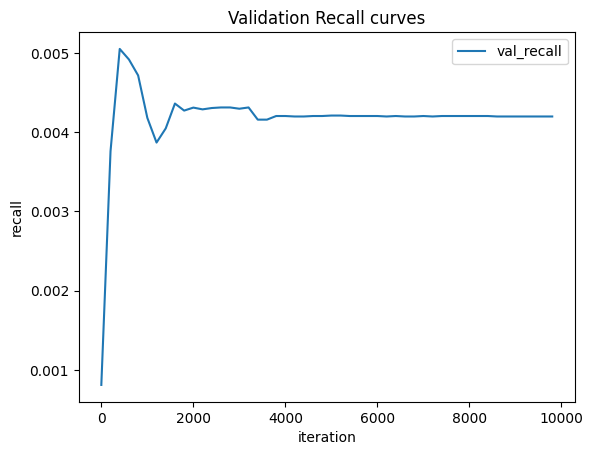

In [292]:
# Code cell
f2 = plt.figure()
plt.plot(iters, val_recall_at_k, label='val_recall')
plt.xlabel('iteration')
plt.ylabel('recall')
plt.title('Validation Recall curves')
plt.legend()
plt.show()

## Evaluation

In [293]:
# Eval the model
model.eval()
test_edge_index = test_edge_index.to(device)
test_recall, test_precision, test_ndcg, test_bpr_loss = evaluate_model(model, test_edge_index, [train_edge_index, val_edge_index], K, LAMBDA)
print(f"test_BPR Loss: {test_bpr_loss}, Recall: {test_recall}, Precision: {test_precision}, NDCG: {test_ndcg}")

test_BPR Loss: -3301.60986328125, Recall: 0.004208520986139774, Precision: 0.002192242769524455, NDCG: 0.003688263474032283
